# Linear Regression

# Volusia County Price Analysis

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras
import pyproj
import folium
import folium.features as ftr
import shapely
import shapely.wkt
import shapely.ops as ops
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [43]:
conn = psycopg2.connect("dbname='spatial' user='postgres' host='volusia-gis.c21rgtvxg36z.us-east-2.rds.amazonaws.com' password='administrator'")

cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

# Houses with 32114 or 32118 ZIP code, single family only, at most 2 years since the sale, price between 50k and 750k
sql1 = "select parid, luc, luc_desc, aprbldg, aprland, aprtot, nbhd, sale_date, price, zip1, rmbed, sfla, total_area, yrblt, misc_area, months_since_sale, ST_AsText(geom) as wkt, water_front, has_pool from volusia.sales_analysis" \
       " where (zip1 ilike '32114' or zip1 ilike '32118')" \
       " and luc_desc ilike 'Single Family'" \
       " and months_since_sale <= 24" \
       " and price > 50000 and price < 750000" 
df = pd.read_sql_query(sql1, conn)

In [44]:
df.head()

,parid,luc,luc_desc,aprbldg,aprland,aprtot,nbhd,sale_date,price,zip1,rmbed,sfla,total_area,yrblt,misc_area,months_since_sale,wkt,water_front,has_pool
0,3535715.0,0100,Single Family,162334.0,23040.0,185374.0,3421,2019-07-26,225000.0,32114,2.0,1398.0,2345.0,1970.0,1001.0,19,"MULTIPOLYGON(((650128.487 1762133.073,650024.5...",0,1
1,3099851.0,0100,Single Family,124865.0,56228.0,181093.0,2262,2020-05-12,190000.0,32118,3.0,1914.0,3257.0,1953.0,330.0,9,"MULTIPOLYGON(((647246.227000002 1790190.949,64...",0,1
2,3136756.0,0100,Single Family,168066.0,71253.0,239319.0,2252,2020-12-15,320000.0,32118,4.0,2020.0,2686.0,1956.0,143.0,2,"MULTIPOLYGON(((649543.328249998 1785400.267,64...",0,1
3,3534913.0,0100,Single Family,138357.0,22800.0,161157.0,3417,2020-01-22,185000.0,32114,3.0,1629.0,2439.0,1973.0,180.0,13,"MULTIPOLYGON(((648577.965 1763498.006,648477.9...",0,1
4,3538510.0,0100,Single Family,117081.0,16380.0,133461.0,3817,2019-11-22,160000.0,32114,2.0,989.0,1736.0,1963.0,100.0,15,"MULTIPOLYGON(((645547.147999998 1762439.891,64...",0,1


In [45]:
parcel_map = folium.Map(location=[29.1887876219045, -81.0494807582431], zoom_start=10, width="100%")

def highlight_function(feature):  
    return
    {
        'weight': 3,
        'color': '#FF0000',
        'dashArray': '',
        'fillOpacity': 0.5
    };

def style_function(feature): 
    return
    {
        'weight': 1.5,
        #'color': 'blue',
        'dashArray': '5, 5',
        'fillOpacity': 0.7
    };

parcel_layer = folium.FeatureGroup(name="parcels")
label_layer = folium.FeatureGroup(name="price_labels")

zillowParids = [4811435, 5056015, 3403851, 3247922, 3568486]

for index, row in df.iterrows():    

    if (row.parid not in zillowParids):
        continue

    tooltip_show = 'Price: ' + str(int(row.price))
    geom = shapely.wkt.loads(row.wkt)
    wgs_geom = ops.transform(pyproj.Transformer.from_crs(pyproj.CRS('EPSG:2236'), pyproj.CRS('EPSG:4326'), always_xy=True) .transform, geom)
    
    parcel_json= folium.GeoJson(shapely.geometry.asShape(wgs_geom),
                       name='parcels',
                       overlay=True,
                       #style_function=style_function,
                       #highlight_function=highlight_function,
                       tooltip=tooltip_show 
    )
    
    popup_string = '<table>'

    for i, v in row.iteritems():
        popup_string += "<tr><td>%10s</td><td>&nbsp;" % i.title() + " " + str(v) + "</td></tr>\n"

    popup_string += "</table>"
    folium.Popup(popup_string).add_to(parcel_json)
    
    parcel_layer.add_child(parcel_json)
    
    divlabel = '<div style="font-size: 14pt; color : black">' + tooltip_show + '</div>'
    marker = folium.Marker(
        [wgs_geom.centroid.y, wgs_geom.centroid.x], 
        icon=ftr.DivIcon(html=divlabel)
    ).add_to(label_layer)

parcel_layer.add_to(parcel_map)
label_layer.add_to(parcel_map)

parcel_map.add_child(folium.LayerControl(position='topright', collapsed=False))

parcel_map.fit_bounds(parcel_layer.get_bounds())

parcel_map

# Data Cleansing

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   parid              781 non-null    float64
 1   luc                781 non-null    object 
 2   luc_desc           781 non-null    object 
 3   aprbldg            781 non-null    float64
 4   aprland            781 non-null    float64
 5   aprtot             781 non-null    float64
 6   nbhd               781 non-null    object 
 7   sale_date          781 non-null    object 
 8   price              781 non-null    float64
 9   zip1               781 non-null    object 
 10  rmbed              781 non-null    float64
 11  sfla               781 non-null    float64
 12  total_area         781 non-null    float64
 13  yrblt              781 non-null    float64
 14  misc_area          781 non-null    float64
 15  months_since_sale  781 non-null    int64  
 16  wkt                781 non

# Feature Selection

In [47]:
corr = df.corr()
print('TOP 3 FEATURES:', df.corr().abs().nlargest(3, 'price').index)

# My first query was for any house in Volusia, limit 5k
# The two top features then were aprland and aprtot
# So, it seems that for ZIP codes 32114 and 32118, aprbldg is more significant than aprland

TOP 3 FEATURES: Index(['price', 'aprtot', 'aprbldg'], dtype='object')


Text(0, 0.5, 'price')

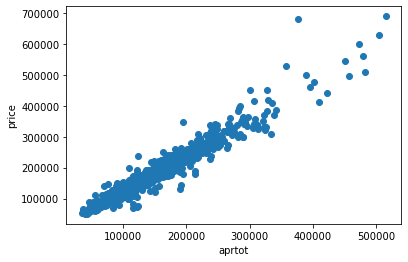

In [48]:
get_ipython().run_line_magic('matplotlib', 'inline')

plt.scatter(df['aprtot'], df['price'], marker='o')
plt.xlabel('aprtot')
plt.ylabel('price')

# aprtot correlates heavily with price

Text(0, 0.5, 'price')

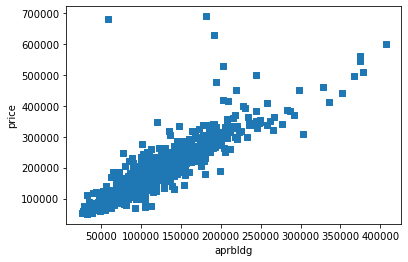

In [49]:
plt.scatter(df['aprbldg'], df['price'], marker='s')
plt.xlabel('aprbldg')
plt.ylabel('price')

# aprbldg correlates heavily with price

# Training the Model (aprtot, aprbldg -> price)

#### Default, top two features, no additions

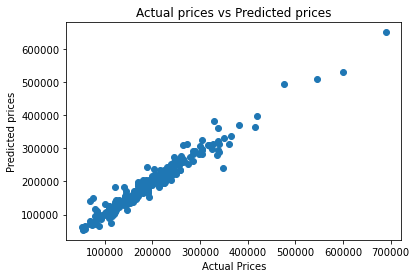

In [50]:
x = pd.DataFrame(np.c_[df['aprtot'], df['aprbldg']], columns = ['aprtot','aprbldg'])
Y = df['price']
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.3, random_state=5)

model = LinearRegression()
model.fit(x_train, Y_train)
price_pred = model.predict(x_test)
plt.scatter(Y_test, price_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.title("Actual prices vs Predicted prices")
plt.show()

In [51]:
mse = mean_squared_error(Y_test, price_pred)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % model.score(x_test, Y_test))
print('Intercept: %.4f'% model.intercept_)
print('Coefficients: ', model.coef_)

MSE: 446243246.4776
R-squared: 0.9463
Intercept: 14534.5869
Coefficients:  [ 1.33388846 -0.27859321]


# Comparing 5 Zillow Prices (aprtot, aprbldg -> price)

In [52]:
def getZillowError(dataframe, ml, columns):
    zillowDetails1 = dataframe.loc[dataframe['parid'] == 4811435]

    zillowDetails2 = dataframe.loc[dataframe['parid'] == 5056015]

    zillowDetails3 = dataframe.loc[dataframe['parid'] == 3403851]

    zillowDetails4 = dataframe.loc[dataframe['parid'] == 3247922]

    zillowDetails5 = dataframe.loc[dataframe['parid'] == 3568486]

    zillowRows =    [zillowDetails1,    zillowDetails2,     zillowDetails3,     zillowDetails4,     zillowDetails5]
    zillowPrices =  [169900,            450000,             299000,             390628,             566822]

    print("DIFFERENCES FROM ZILLOW PRICES")
    # multi family parid=3521706 or parid=3524047

    for i in range(len(zillowRows)):
        print("For parid {0}: ".format(zillowRows[i]['parid'].item()), round(float(abs(((ml.predict(zillowRows[i][columns])) - zillowPrices[i]))/zillowPrices[i] * 100), 2), '%')

getZillowError(df, model, ['aprtot', 'aprbldg'])

DIFFERENCES FROM ZILLOW PRICES
For parid 4811435.0:  36.63 %
For parid 5056015.0:  64.88 %
For parid 3403851.0:  12.22 %
For parid 3247922.0:  22.28 %
For parid 3568486.0:  2.43 %


# Training the Model (aprtot, aprbldg, elev -> price)

### Added Procko's Parcel Elevation Numbers

In [53]:
sql1 = "select s.parid as parid, s.price, s.aprtot, s.aprbldg, ca.elev from volusia.sales_analysis s, volusia.contours_analysis2 ca" \
       " where (s.zip1 ilike '32114' or s.zip1 ilike '32118')" \
       " and s.luc_desc ilike 'Single Family'" \
       " and s.months_since_sale <= 24" \
       " and s.price > 50000 and s.price < 750000" \
       " and s.parid = ca.parid"
df = pd.read_sql_query(sql1, conn)

Text(0, 0.5, 'price')

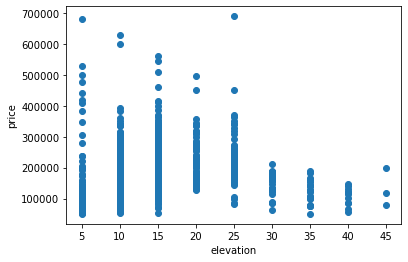

In [54]:
corr = df.corr()

plt.scatter(df['elev'], df['price'], marker='o')
plt.xlabel('elevation')
plt.ylabel('price')

# Elevation does seem to correlate with prices, in this fashion:
# Higher elevations correlate with lower prices
# Lower elevations correlate with higher prices
# This makes sense, since the ZIP codes used were for Daytona Beach, which is mostly beachfront/close to beach houses
# Therefore, it is assumed that people pay a premium for beach life, at the expense of lower elevation

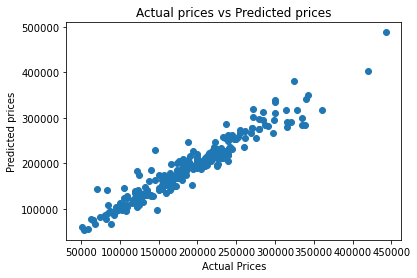

DIFFERENCES FROM ZILLOW PRICES
For parid 4811435.0:  37.09 %
For parid 5056015.0:  65.25 %
For parid 3403851.0:  11.32 %
For parid 3247922.0:  21.56 %
For parid 3568486.0:  0.81 %


In [55]:
clmns = ['aprtot','aprbldg','elev']

x = pd.DataFrame(np.c_[df['aprtot'], df['aprbldg'], df['elev']], columns = clmns)
Y = df['price']
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.3, random_state=5)

model = LinearRegression()
model.fit(x_train, Y_train)
price_pred = model.predict(x_test)
plt.scatter(Y_test, price_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.title("Actual prices vs Predicted prices")
plt.show()

getZillowError(df, model, clmns)

In [56]:
mse = mean_squared_error(Y_test, price_pred)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % model.score(x_test, Y_test))
print('Intercept: %.4f'% model.intercept_)
print('Coefficients: ', model.coef_)

MSE: 400766684.4555
R-squared: 0.9192
Intercept: 14223.6218
Coefficients:  [   1.34511338   -0.26169093 -154.20792348]


# Training the Model (aprtot, aprbldg, elev, groc -> price)

### Added Fawzia's Grocery Distance Numbers

In [57]:
sql1 = "select s.parid as parid, s.price, s.aprtot, s.aprbldg, ca.elev, gd.groc_distance from volusia.sales_analysis s, volusia.contours_analysis2 ca, volusia.groceries_distance gd" \
       " where (s.zip1 ilike '32114' or s.zip1 ilike '32118')" \
       " and s.luc_desc ilike 'Single Family'" \
       " and s.months_since_sale <= 24" \
       " and s.price > 50000 and s.price < 750000" \
       " and s.parid = ca.parid and s.parid = gd.parid"
df = pd.read_sql_query(sql1, conn)

Text(0, 0.5, 'price')

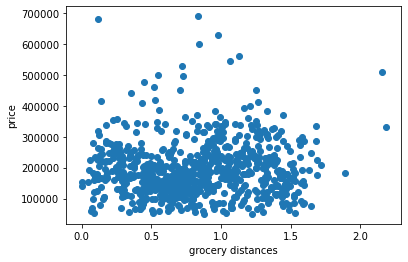

In [58]:
corr = df.corr()

plt.scatter(df['groc_distance'], df['price'], marker='o')
plt.xlabel('grocery distances')
plt.ylabel('price')

# No observable correlation with grocery distances

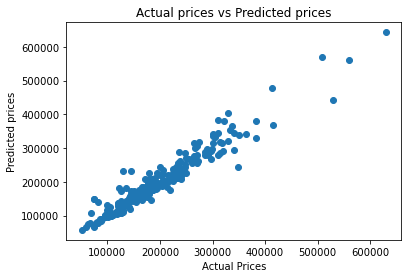

DIFFERENCES FROM ZILLOW PRICES
For parid 4811435.0:  38.2 %
For parid 5056015.0:  65.0 %
For parid 3403851.0:  11.42 %
For parid 3247922.0:  21.08 %
For parid 3568486.0:  0.42 %


In [59]:
clmns = ['aprtot','aprbldg','elev','groc_distance']

x = pd.DataFrame(np.c_[df['aprtot'], df['aprbldg'], df['elev'], df['groc_distance']], columns = clmns)
Y = df['price']
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.3, random_state=5)

model = LinearRegression()
model.fit(x_train, Y_train)
price_pred = model.predict(x_test)
plt.scatter(Y_test, price_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.title("Actual prices vs Predicted prices")
plt.show()

getZillowError(df, model, clmns)

In [60]:
mse = mean_squared_error(Y_test, price_pred)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % model.score(x_test, Y_test))
print('Intercept: %.4f'% model.intercept_)
print('Coefficients: ', model.coef_)

MSE: 632633605.4250
R-squared: 0.9194
Intercept: 9897.2797
Coefficients:  [ 1.35362507e+00 -2.58593579e-01 -6.53902784e+01  2.18259076e+03]


# Training the Model (aprtot, aprbldg, elev, groc, schools -> price)

### Added Tim Elvira's School Distance Numbers

In [61]:
sql1 = "select s.parid as parid, s.price, s.aprtot, s.aprbldg, ca.elev, gd.groc_distance, sz.distance_to_elem_school, sz.distance_to_middle_school, sz.distance_to_high_school, sz.nearest_elem_school, sz.nearest_middle_school, sz.nearest_high_school from volusia.sales_analysis s, volusia.contours_analysis2 ca, volusia.groceries_distance gd," \
       " volusia.schoolzones sz" \
       " where (s.zip1 ilike '32114' or s.zip1 ilike '32118')" \
       " and s.luc_desc ilike 'Single Family'" \
       " and s.months_since_sale <= 24" \
       " and s.price > 50000 and s.price < 750000" \
       " and s.parid = ca.parid and s.parid = gd.parid and s.parid = sz.parid"
df = pd.read_sql_query(sql1, conn)

Text(0, 0.5, 'price')

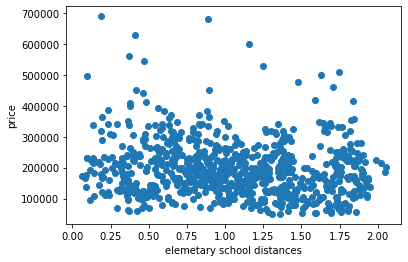

In [62]:
corr = df.corr()

plt.scatter(df['distance_to_elem_school'], df['price'], marker='o')
plt.xlabel('elemetary school distances')
plt.ylabel('price')

# No observable correlation with elementary school distances

Text(0, 0.5, 'price')

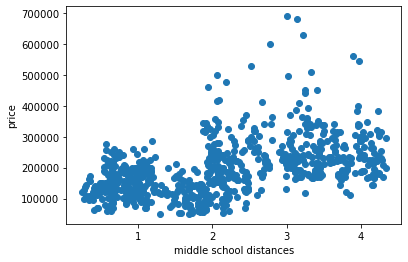

In [63]:
plt.scatter(df['distance_to_middle_school'], df['price'], marker='o')
plt.xlabel('middle school distances')
plt.ylabel('price')

# Possible, very loose correlation with middle school distances

Text(0, 0.5, 'price')

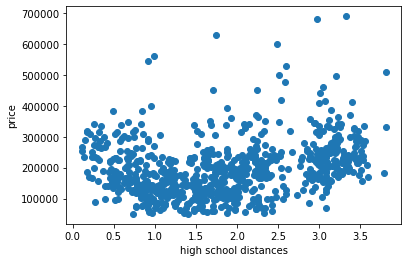

In [64]:
plt.scatter(df['distance_to_high_school'], df['price'], marker='o')
plt.xlabel('high school distances')
plt.ylabel('price')

# No observable correlation with high school distances

Text(0, 0.5, 'price')

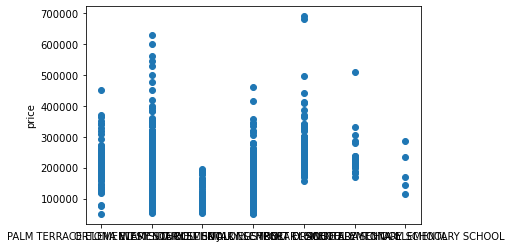

In [65]:
plt.scatter(df['nearest_elem_school'], df['price'], marker='o')
plt.xlabel('')
plt.ylabel('price')
# Possible indication that the second and last elementary schools being nearest may indicate lower property value

Text(0, 0.5, 'price')

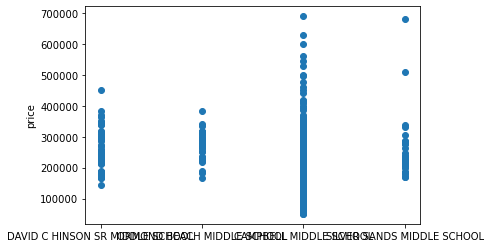

In [66]:
plt.scatter(df['nearest_middle_school'], df['price'], marker='o')
plt.xlabel('')
plt.ylabel('price')

# No observable correlation with nearest middle schools

Text(0, 0.5, 'price')

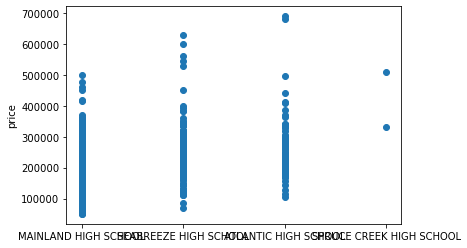

In [67]:
plt.scatter(df['nearest_high_school'], df['price'], marker='o')
plt.xlabel('')
plt.ylabel('price')

# No observable correlation with nearest high schools

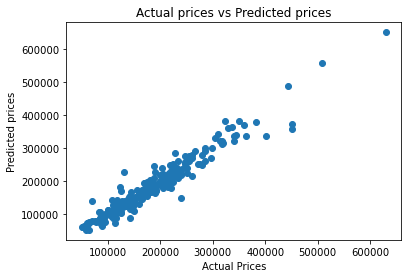

DIFFERENCES FROM ZILLOW PRICES
For parid 4811435.0:  37.17 %
For parid 5056015.0:  64.89 %
For parid 3403851.0:  11.6 %
For parid 3247922.0:  21.33 %
For parid 3568486.0:  1.35 %


In [68]:
# No great correlation with nearest school names, so we're going to leave that out of the model
# Also we can't put them in the model because they aren't numerical... we'd have to normalize them to numbers

clmns = ['aprtot', 'aprbldg', 'elev', 'groc_distance', 'distance_to_elem_school', 'distance_to_middle_school', 'distance_to_high_school']

x = pd.DataFrame(
    np.c_[df['aprtot'], df['aprbldg'], 
          df['elev'], 
          df['groc_distance'], 
          df['distance_to_elem_school'], df['distance_to_middle_school'], df['distance_to_high_school']],
    columns = clmns)
Y = df['price']
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.3, random_state=5)

model = LinearRegression()
model.fit(x_train, Y_train)
price_pred = model.predict(x_test)
plt.scatter(Y_test, price_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.title("Actual prices vs Predicted prices")
plt.show()

getZillowError(df, model, clmns)

In [69]:
mse = mean_squared_error(Y_test, price_pred)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % model.score(x_test, Y_test))
print('Intercept: %.4f'% model.intercept_)
print('Coefficients: ', model.coef_)

MSE: 517017254.7214
R-squared: 0.9313
Intercept: 14409.2561
Coefficients:  [ 1.38835143e+00 -3.06775188e-01 -9.66499629e+01 -1.77744964e+03
  4.89193919e+02  1.06840327e+03 -2.22878229e+03]


# Training the Model (aprtot, aprbldg, elev, groc, schools, flood -> price)

### Added Kevin Dumitrescu's Flood Zone Distance Numbers

In [70]:
sql1 = "select s.parid as parid, s.price, s.aprtot, s.aprbldg, ca.elev, gd.groc_distance, sz.distance_to_elem_school, sz.distance_to_middle_school, sz.distance_to_high_school, sz.nearest_elem_school, sz.nearest_middle_school, sz.nearest_high_school, fz.fzdistance from volusia.sales_analysis s, volusia.contours_analysis2 ca, volusia.groceries_distance gd," \
       " volusia.schoolzones sz, volusia.floodzones fz" \
       " where (s.zip1 ilike '32114' or s.zip1 ilike '32118')" \
       " and s.luc_desc ilike 'Single Family'" \
       " and s.months_since_sale <= 24" \
       " and s.price > 50000 and s.price < 750000" \
       " and s.parid = ca.parid and s.parid = gd.parid and s.parid = sz.parid and s.parid=fz.parid"
df = pd.read_sql_query(sql1, conn)

Text(0, 0.5, 'price')

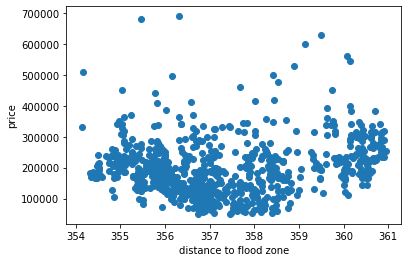

In [71]:
corr = df.corr()

plt.scatter(df['fzdistance'], df['price'], marker='o')
plt.xlabel('distance to flood zone')
plt.ylabel('price')

# No observable correlation with flood zone distance

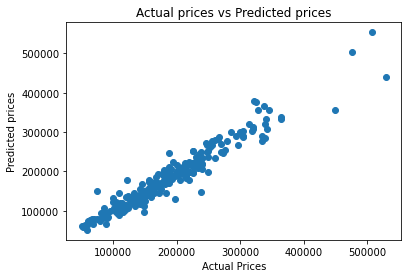

DIFFERENCES FROM ZILLOW PRICES
For parid 4811435.0:  36.69 %
For parid 5056015.0:  64.76 %
For parid 3403851.0:  12.77 %
For parid 3247922.0:  21.41 %
For parid 3568486.0:  2.26 %


In [72]:
clmns = ['aprtot', 'aprbldg', 'elev', 'groc_distance', 'distance_to_elem_school', 'distance_to_middle_school', 'distance_to_high_school', 'fzdistance']

x = pd.DataFrame(
    np.c_[df['aprtot'], df['aprbldg'], 
          df['elev'], 
          df['groc_distance'], 
          df['distance_to_elem_school'], df['distance_to_middle_school'], df['distance_to_high_school'],
          df['fzdistance']],
    columns = clmns)

Y = df['price']
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.3, random_state=5)

model = LinearRegression()
model.fit(x_train, Y_train)
price_pred = model.predict(x_test)
plt.scatter(Y_test, price_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.title("Actual prices vs Predicted prices")
plt.show()

getZillowError(df, model, clmns)

In [73]:
mse = mean_squared_error(Y_test, price_pred)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % model.score(x_test, Y_test))
print('Intercept: %.4f'% model.intercept_)
print('Coefficients: ', model.coef_)

MSE: 498546121.1245
R-squared: 0.9242
Intercept: 294120.4802
Coefficients:  [ 1.38626078e+00 -3.10150058e-01 -1.35680398e+02 -2.75780577e+03
  7.87054784e+02  1.31387521e+03 -4.25684508e+03 -7.72178587e+02]


# Training the Model (aprtot, aprbldg, elev, groc, schools, flood, railroads -> price)

### Tim Bernard's Railroad Track Distance Numbers

In [74]:
sql1 = "select s.parid as parid, s.price, s.aprtot, s.aprbldg, ca.elev, gd.groc_distance, sz.distance_to_elem_school, sz.distance_to_middle_school, sz.distance_to_high_school, sz.nearest_elem_school, sz.nearest_middle_school, sz.nearest_high_school, fz.fzdistance, rr.rrdistance from volusia.sales_analysis s, volusia.contours_analysis2 ca, volusia.groceries_distance gd," \
       " volusia.schoolzones sz, volusia.floodzones fz, volusia.railroads rr" \
       " where (s.zip1 ilike '32114' or s.zip1 ilike '32118')" \
       " and s.luc_desc ilike 'Single Family'" \
       " and s.months_since_sale <= 24" \
       " and s.price > 50000 and s.price < 750000" \
       " and s.parid = ca.parid and s.parid = gd.parid and s.parid = sz.parid and s.parid=fz.parid and s.parid=rr.parid"
df = pd.read_sql_query(sql1, conn)

Text(0, 0.5, 'price')

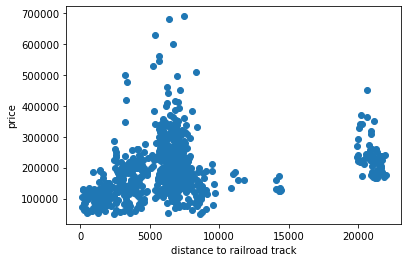

In [75]:
corr = df.corr()

plt.scatter(df['rrdistance'], df['price'], marker='o')
plt.xlabel('distance to railroad track')
plt.ylabel('price')

# No observable correlation with distance to railroad tracks...
# But the correlation graph below is very interesting
# It seems that the last group (~20000+ distance to a railroad track) has a lower limit well above the other lower limits
# Perhaps houses cost a bit more so you do not hear the trains

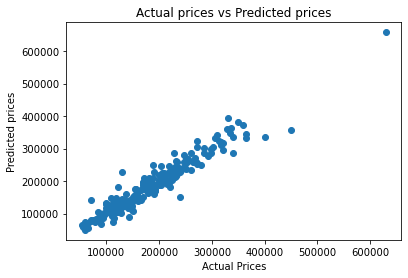

DIFFERENCES FROM ZILLOW PRICES
For parid 4811435.0:  41.33 %
For parid 5056015.0:  64.41 %
For parid 3403851.0:  11.53 %
For parid 3247922.0:  20.18 %
For parid 3568486.0:  2.51 %


In [76]:
clmns = ['aprtot', 'aprbldg', 'elev', 'groc_distance', 'distance_to_elem_school', 'distance_to_middle_school', 'distance_to_high_school', 'fzdistance', 'rrdistance']

x = pd.DataFrame(
    np.c_[df['aprtot'], df['aprbldg'], 
          df['elev'], 
          df['groc_distance'], 
          df['distance_to_elem_school'], df['distance_to_middle_school'], df['distance_to_high_school'],
          df['fzdistance'],
          df['rrdistance']],
    columns = clmns)

Y = df['price']
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.3, random_state=5)

model = LinearRegression()
model.fit(x_train, Y_train)
price_pred = model.predict(x_test)
plt.scatter(Y_test, price_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.title("Actual prices vs Predicted prices")
plt.show()

getZillowError(df, model, clmns)

In [77]:
mse = mean_squared_error(Y_test, price_pred)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % model.score(x_test, Y_test))
print('Intercept: %.4f'% model.intercept_)
print('Coefficients: ', model.coef_)

MSE: 507968207.7975
R-squared: 0.9205
Intercept: -437215.0193
Coefficients:  [ 1.41645536e+00 -3.47554429e-01 -4.05180780e+02 -7.94539367e+02
  2.90305161e+02 -2.56708915e+03 -2.50233402e+03  1.27878889e+03
  1.19835729e+00]


# Training the Model (aprtot, aprbldg, elev, groc, schools, flood, railroads, boatramps -> price)

### Kody Miller's Boatramp/Marina Distance Numbers

In [78]:
sql1 = "select s.parid as parid, s.price, s.aprtot, s.aprbldg, ca.elev, gd.groc_distance, sz.distance_to_elem_school, sz.distance_to_middle_school, sz.distance_to_high_school, sz.nearest_elem_school, sz.nearest_middle_school, sz.nearest_high_school, fz.fzdistance, rr.rrdistance, br.br_distance, br.mar_distance from volusia.sales_analysis s, volusia.contours_analysis2 ca, volusia.groceries_distance gd," \
       " volusia.schoolzones sz, volusia.floodzones fz, volusia.railroads rr, volusia.boatramps br" \
       " where (s.zip1 ilike '32114' or s.zip1 ilike '32118')" \
       " and s.luc_desc ilike 'Single Family'" \
       " and s.months_since_sale <= 24" \
       " and s.price > 50000 and s.price < 750000" \
       " and s.parid = ca.parid and s.parid = gd.parid and s.parid = sz.parid and s.parid=fz.parid" \
       " and s.parid=rr.parid and s.parid=br.parid"
df = pd.read_sql_query(sql1, conn)

Text(0, 0.5, 'price')

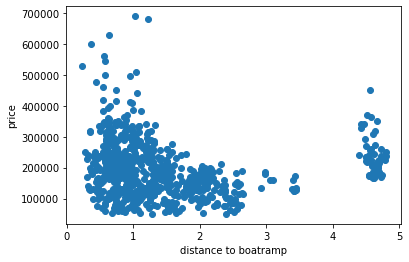

In [79]:
corr = df.corr()

plt.scatter(df['br_distance'], df['price'], marker='o')
plt.xlabel('distance to boatramp')
plt.ylabel('price')

# More of an outlier situation with this feature
# The cluster on the tail end is interesting, but I cannot speculate as to why it's there
# But it can be seen that, somewhat, prices increase the closer boatramps are

Text(0, 0.5, 'price')

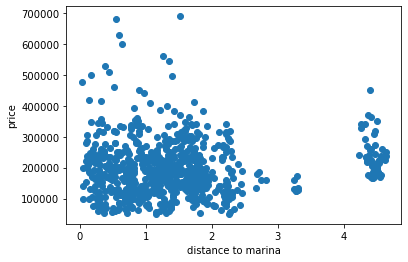

In [80]:
corr = df.corr()

plt.scatter(df['mar_distance'], df['price'], marker='o')
plt.xlabel('distance to marina')
plt.ylabel('price')

# Same situation as the boatramp feature, see above

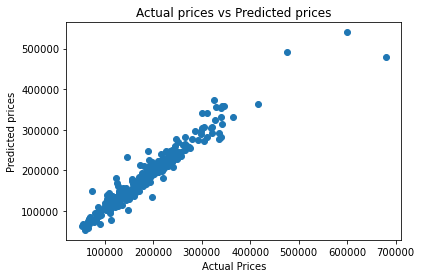

DIFFERENCES FROM ZILLOW PRICES
For parid 4811435.0:  41.47 %
For parid 5056015.0:  63.84 %
For parid 3403851.0:  12.47 %
For parid 3247922.0:  19.83 %
For parid 3568486.0:  3.21 %


In [81]:
clmns = ['aprtot', 'aprbldg', 'elev', 'groc_distance', 'distance_to_elem_school', 'distance_to_middle_school', 'distance_to_high_school', 'fzdistance', 'rrdistance', 'br_distance', 'mar_distance']

x = pd.DataFrame(
    np.c_[df['aprtot'], df['aprbldg'], 
          df['elev'], 
          df['groc_distance'], 
          df['distance_to_elem_school'], df['distance_to_middle_school'], df['distance_to_high_school'],
          df['fzdistance'],
          df['rrdistance'],
          df['br_distance'], df['mar_distance']],
    columns = clmns)

Y = df['price']
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.3, random_state=5)

model = LinearRegression()
model.fit(x_train, Y_train)
price_pred = model.predict(x_test)
plt.scatter(Y_test, price_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.title("Actual prices vs Predicted prices")
plt.show()

getZillowError(df, model, clmns)

In [82]:
mse = mean_squared_error(Y_test, price_pred)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % model.score(x_test, Y_test))
print('Intercept: %.4f'% model.intercept_)
print('Coefficients: ', model.coef_)

MSE: 572367641.8318
R-squared: 0.9222
Intercept: -1117942.2527
Coefficients:  [ 1.29041971e+00 -2.00640718e-01 -1.84087676e+02  1.35143246e+03
 -1.20813255e+03 -1.42743517e+03 -1.34641084e+01  3.15933096e+03
  4.84999954e-02  7.93963317e+03 -2.95321516e+03]


## I think that a lot of these features are subsumed by one general measure, at least for the zip codes close to the beach: "distance from ocean"

### If this feature could be calculated, then elevation, floodzones and boatramps would likely fall under it. I don't know if this would provide you with a more accurate model in the end.

### I think the biggest reduction in the model quality comes from measures like "distance to grocery store" or "railroad track distance"... these do not seem to correlate very strongly.